<a href="https://colab.research.google.com/github/samyogbhatta/MLPC-IndividualAssignmet-Wildfire/blob/main/MlpcModel(GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#un rr the file
!apt-get install unrar
!unrar x /content/drive/MyDrive/Dataset.rar /content/


Libraries Import

In [ ]:
import os
import cv2
import random
import tensorflow as tf
from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np




Path giving

In [ ]:
train_dir = '/content/Dataset/Training and Validation'
test_dir = '/content/Dataset/Testing'


Preprocess

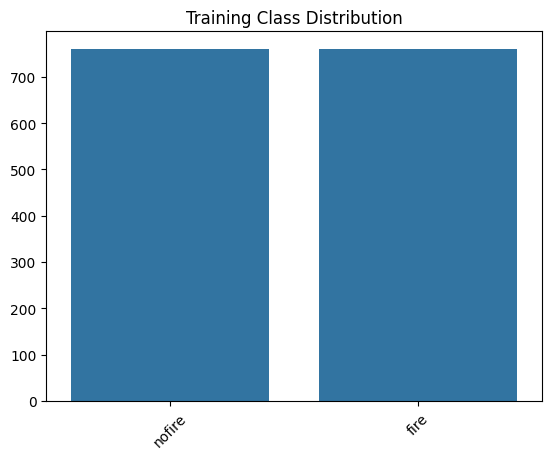

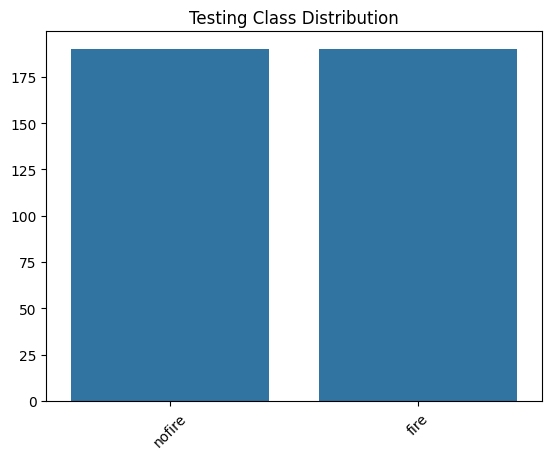

In [ ]:
# Plot Class Distribution
def get_class_counts(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts

def plot_class_distribution(counts, title):
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

train_counts = get_class_counts(train_dir)
test_counts = get_class_counts(test_dir)

plot_class_distribution(train_counts, 'Training Class Distribution')
plot_class_distribution(test_counts, 'Testing Class Distribution')

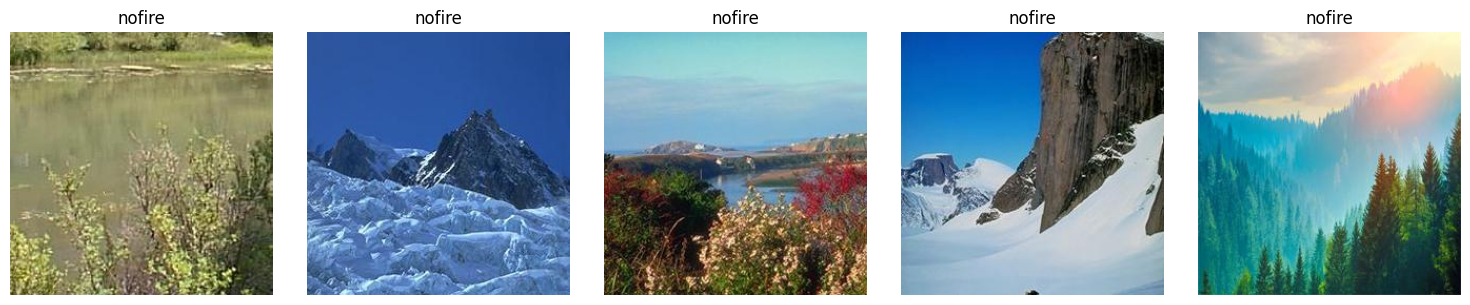

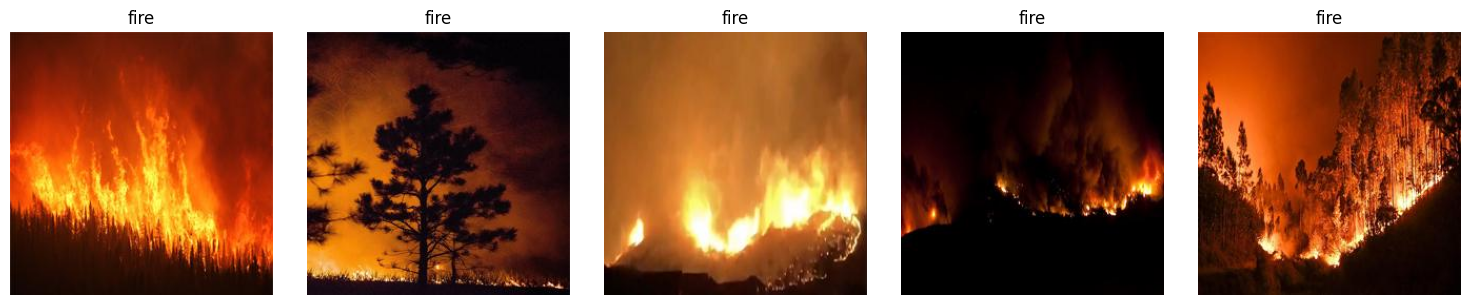

In [ ]:
# Sample Images Plot
def plot_sample_images(directory, num_samples=5):
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for cls in classes:
        plt.figure(figsize=(15, 3))
        folder = os.path.join(directory, cls)
        images = random.sample(os.listdir(folder), min(num_samples, len(os.listdir(folder))))
        for i, img_name in enumerate(images):
            img = cv2.imread(os.path.join(folder, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

plot_sample_images(train_dir)

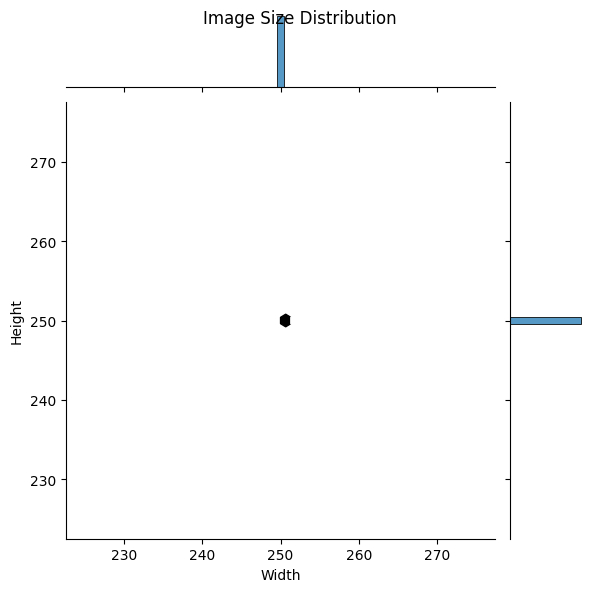

In [ ]:
# Image Size Distribution
def get_image_sizes(directory):
    sizes = []
    for cls in os.listdir(directory):
        class_folder = os.path.join(directory, cls)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                try:
                    img = Image.open(img_path)
                    sizes.append(img.size)
                except:
                    pass  # Skip corrupted
    return sizes

train_sizes = get_image_sizes(train_dir)
sizes_df = pd.DataFrame(train_sizes, columns=['Width', 'Height'])

sns.jointplot(data=sizes_df, x="Width", y="Height", kind="hex")
plt.suptitle('Image Size Distribution')
plt.show()

We got of size 256*256

In [ ]:
# --- Image Data Generator with Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation split
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# --- Data Loaders ---
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1216 images belonging to 2 classes.
Found 304 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


Model design

In [ ]:
# --- CNN Model ---
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# --- Compile ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

start = time.time()
history = model.fit(train_generator, epochs=15, validation_data=validation_generator)
end = time.time()

print(f'\nGPU Training Time: {end - start:.2f} seconds')


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 228ms/step - accuracy: 0.9751 - loss: 0.0904 - val_accuracy: 0.9737 - val_loss: 0.0822
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9850 - loss: 0.0533 - val_accuracy: 0.9803 - val_loss: 0.0775
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.9873 - loss: 0.0324 - val_accuracy: 0.9868 - val_loss: 0.0830
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9914 - loss: 0.0264 - val_accuracy: 0.9803 - val_loss: 0.0785
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.9934 - loss: 0.0257 - val_accuracy: 0.9868 - val_loss: 0.0950
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.9938 - loss: 0.0238 - val_accuracy: 0.9803 - val_loss: 0.1033
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.9871 - loss: 0.0440 - val_accuracy: 0.9737 - val_loss: 0.0752
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.9812 - loss: 0.0419 - val_accuracy: 

Testing

In [ ]:
# --- Evaluate on Test Set ---
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy GPU (USED): {test_acc:.4f}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9317 - loss: 0.3442

Test Accuracy GPU (USED): 0.9526


Visualization accuracy

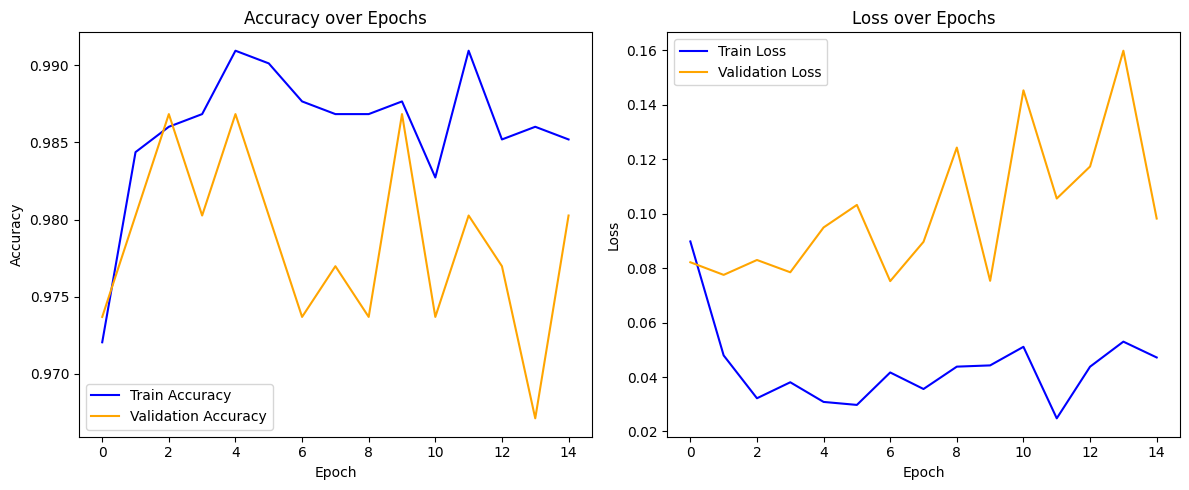

In [ ]:
# --- Accuracy & Loss Visualization ---
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


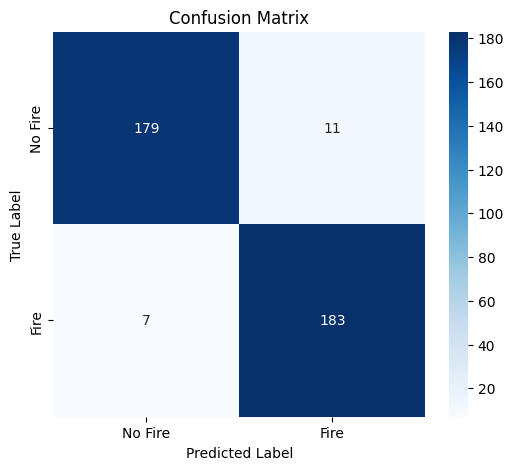

              precision    recall  f1-score   support

     No Fire       0.96      0.94      0.95       190
        Fire       0.94      0.96      0.95       190

    accuracy                           0.95       380
   macro avg       0.95      0.95      0.95       380
weighted avg       0.95      0.95      0.95       380



In [ ]:

# Get true labels and predictions
Y_true = []
Y_pred = []

# Loop over batches in the test generator
for images, labels in test_generator:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int)  # Threshold for binary classification
    Y_true.extend(labels)
    Y_pred.extend(preds.flatten())

    if len(Y_true) >= test_generator.samples:  # Ensure we only predict on the full dataset once
        break

# Create confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optional: Classification Report
print(classification_report(Y_true, Y_pred, target_names=['No Fire', 'Fire']))


In [ ]:
# Save the model in HDF5 format (.h5)
model.save('fire_detection_model(gpu).h5')


Latency of GPU

In [ ]:
import time
import numpy as np

# Reset the generator to make sure it starts from the beginning
test_generator.reset()

# Get one batch of images from the test generator (batch size = 32)
images_batch, labels_batch = next(test_generator)

# --- Latency Measurement ---
start_time = time.time()
predictions = model.predict(images_batch)
end_time = time.time()

# --- Results ---
latency_per_batch = end_time - start_time
latency_per_image = latency_per_batch / images_batch.shape[0]

print(f"Latency per batch (32 images): {latency_per_batch:.4f} seconds")
print(f"Latency per image: {latency_per_image:.4f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Latency per batch (32 images): 0.0684 seconds
Latency per image: 0.0021 seconds
